Libraries

In [17]:
import torch
import torch.nn as nn
import snntorch as snn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import math

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

MNIST data set loader

In [18]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

creating SNN

In [ ]:
def create_snn(hidden1, hidden2, beta):
    class SNNModel(nn.Module):
        def __init__(self):
            super().__init__()
            # Define linear layers
            self.fc1 = nn.Linear(28*28, hidden1)
            self.lif1 = snn.Leaky(beta=beta)
            self.fc2 = nn.Linear(hidden1, hidden2)
            self.lif2 = snn.Leaky(beta=beta)
            self.fc3 = nn.Linear(hidden2, 10)
            self.lif3 = snn.Leaky(beta=beta)

        def forward(self, x, num_steps=10):
            # Initialize membrane potentials
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()
            mem3 = self.lif3.init_leaky()
            spk_out = 0
            for _ in range(num_steps):
                cur1 = self.fc1(x.view(x.size(0), -1))
                spk1, mem1 = self.lif1(cur1, mem1)
                cur2 = self.fc2(spk1)
                spk2, mem2 = self.lif2(cur2, mem2)
                cur3 = self.fc3(spk2)
                spk3, mem3 = self.lif3(cur3, mem3)
                spk_out += spk3
            return spk_out / num_steps
    return SNNModel()x

Creating muataion

In [20]:
def bounded_mutation(individual, bounds, mu=0, sigma=0.2, indpb=0.2):
    """Custom mutation that keeps values within specified bounds"""
    for i, (low, high) in enumerate(bounds):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma * (high - low))
            individual[i] = max(low, min(high, individual[i]))
    return individual,
def evaluate_model(individual):
    hidden1 = max(64, min(256, int(round(individual[0]))))
    hidden2 = max(64, min(256, int(round(individual[1]))))
    beta = max(0.5, min(0.99, float(individual[2])))
    lr = max(0.0001, min(0.01, float(individual[3])))

    model = create_snn(hidden1, hidden2, beta)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        if batch_idx >= 20:
            break

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, pred = outputs.max(1)
            total += targets.size(0)
            correct += (pred == targets).sum().item()
            if total >= 1000:
                break
    accuracy = correct / total
    return (accuracy,)

Creating plotting

In [21]:
def plot_individual(individual, ax, color='blue', alpha=0.7):
    """Plot a single individual's parameters as a bar chart"""
    params = ['Hidden1', 'Hidden2', 'Beta', 'LR×1000']
    values = [individual[0], individual[1], individual[2], individual[3]*1000] 
    
    bars = ax.bar(params, values, color=color, alpha=alpha)
    ax.set_ylim(0, 300)
    ax.set_ylabel('Parameter Value')
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=8)

def plot_population(population, generation, min_fitness, max_fitness):
    """Plot population diversity and fitness distribution"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    hidden1_vals = [ind[0] for ind in population]
    hidden2_vals = [ind[1] for ind in population]
    beta_vals = [ind[2] for ind in population]
    lr_vals = [ind[3] for ind in population]
    fitness_vals = [ind.fitness.values[0] if ind.fitness.valid else 0 for ind in population]
    scatter1 = ax1.scatter(hidden1_vals, hidden2_vals, c=fitness_vals, 
                          cmap='viridis', s=100, alpha=0.7, vmin=min_fitness, vmax=max_fitness)
    ax1.set_xlabel('Hidden Layer 1 Size')
    ax1.set_ylabel('Hidden Layer 2 Size')
    ax1.set_title(f'Gen {generation}: Layer Sizes vs Fitness')
    ax1.grid(True, alpha=0.3)

    scatter2 = ax2.scatter(beta_vals, lr_vals, c=fitness_vals, 
                          cmap='viridis', s=100, alpha=0.7, vmin=min_fitness, vmax=max_fitness)
    ax2.set_xlabel('Beta (Leak Factor)')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title(f'Gen {generation}: Beta vs Learning Rate')
    ax2.grid(True, alpha=0.3)

    ax3.hist(fitness_vals, bins=max(3, len(population)//2), alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(np.mean(fitness_vals), color='red', linestyle='--', label=f'Mean: {np.mean(fitness_vals):.3f}')
    ax3.axvline(np.max(fitness_vals), color='green', linestyle='--', label=f'Max: {np.max(fitness_vals):.3f}')
    ax3.set_xlabel('Fitness (Accuracy)')
    ax3.set_ylabel('Count')
    ax3.set_title(f'Gen {generation}: Fitness Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    best_idx = np.argmax(fitness_vals)
    best_individual = population[best_idx]
    plot_individual(best_individual, ax4, color='gold')
    ax4.set_title(f'Gen {generation}: Best Individual (Acc: {fitness_vals[best_idx]:.3f})')
    
    cbar = plt.colorbar(scatter1, ax=ax4)
    cbar.set_label('Fitness (Accuracy)')
    
    plt.tight_layout()
    return fig

Plotting progression

In [22]:
def plot_evolution_progress(logbook):
    """Plot evolution statistics over generations"""
    gen = logbook.select("gen")
    avg_fitness = logbook.select("avg")
    max_fitness = logbook.select("max")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(gen, avg_fitness, 'b-', label='Average Fitness', linewidth=2, marker='o')
    ax1.plot(gen, max_fitness, 'r-', label='Maximum Fitness', linewidth=2, marker='s')
    ax1.fill_between(gen, avg_fitness, max_fitness, alpha=0.2)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness (Accuracy)')
    ax1.set_title('Evolution Progress: Fitness Over Generations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    improvement = np.diff(max_fitness)
    ax2.bar(gen[1:], improvement, alpha=0.7, color=['green' if x > 0 else 'red' for x in improvement])
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness Improvement')
    ax2.set_title('Generation-to-Generation Improvement')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_architecture_evolution(populations_history):
    """Plot how architecture parameters evolved over time"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    param_names = ['Hidden Layer 1', 'Hidden Layer 2', 'Beta (Leak Factor)', 'Learning Rate']
    param_indices = [0, 1, 2, 3]
    
    for idx, (ax, param_name, param_idx) in enumerate(zip(axes.flat, param_names, param_indices)):

        for gen, population_data in enumerate(populations_history):

            values = [ind_data[param_idx] for ind_data in population_data]
            fitness = [ind_data[4] for ind_data in population_data]

            scatter = ax.scatter([gen] * len(values), values, c=fitness, 
                              cmap='viridis', alpha=0.6, s=50)
        
        ax.set_xlabel('Generation')
        ax.set_ylabel(param_name)
        ax.set_title(f'Evolution of {param_name}')
        ax.grid(True, alpha=0.3)

    if len(populations_history) > 0:
        cbar = plt.colorbar(scatter, ax=axes.flat[-1])
        cbar.set_label('Fitness (Accuracy)')
    
    plt.tight_layout()
    return fig

Set up  DEAP

In [23]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

BOUNDS = [(64, 256), (64, 256), (0.5, 0.99), (0.0001, 0.01)]

toolbox = base.Toolbox()
toolbox.register("hidden1", random.uniform, 64, 256)
toolbox.register("hidden2", random.uniform, 64, 256)
toolbox.register("beta", random.uniform, 0.5, 0.99)
toolbox.register("lr", random.uniform, 0.0001, 0.01)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.hidden1, toolbox.hidden2, toolbox.beta, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", bounded_mutation, bounds=BOUNDS, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Running the evolution

gen	nevals	avg     	max     	min    
0  	8     	0.611816	0.761719	0.43457
1  	6     	0.706299	0.753906	0.635742
2  	6     	0.751221	0.822266	0.703125
3  	6     	0.745117	0.822266	0.667969
4  	3     	0.756592	0.822266	0.722656
5  	6     	0.758301	0.822266	0.691406
6  	5     	0.766479	0.822266	0.741211
7  	5     	0.765015	0.822266	0.731445
8  	2     	0.775024	0.822266	0.707031
9  	4     	0.75354 	0.822266	0.699219
10 	6     	0.760498	0.805664	0.719727

Generating visualizations...


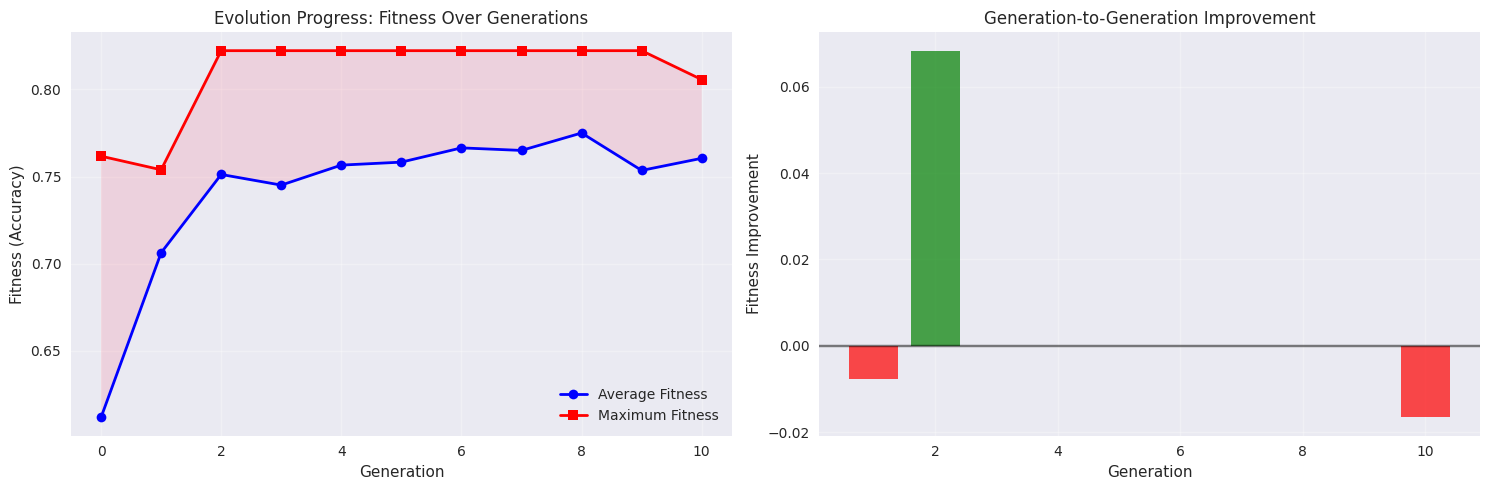

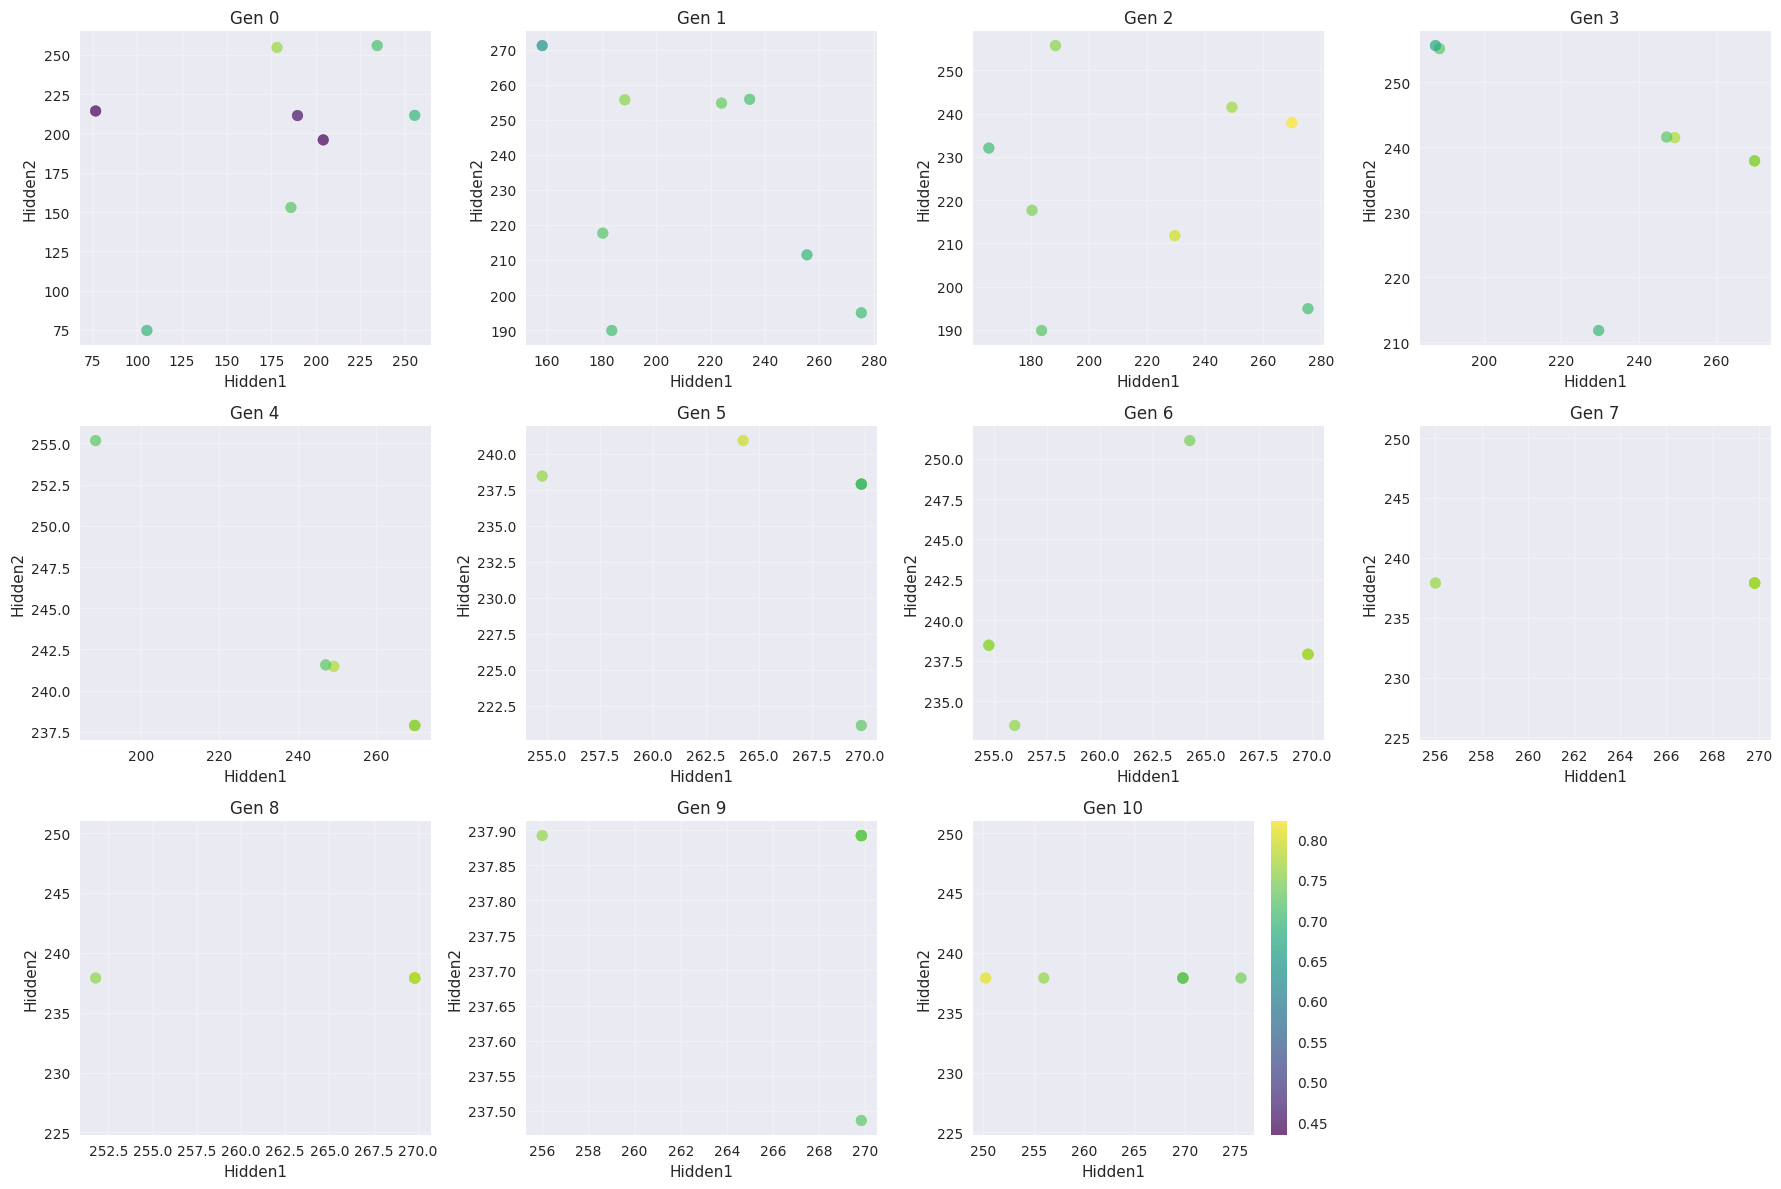

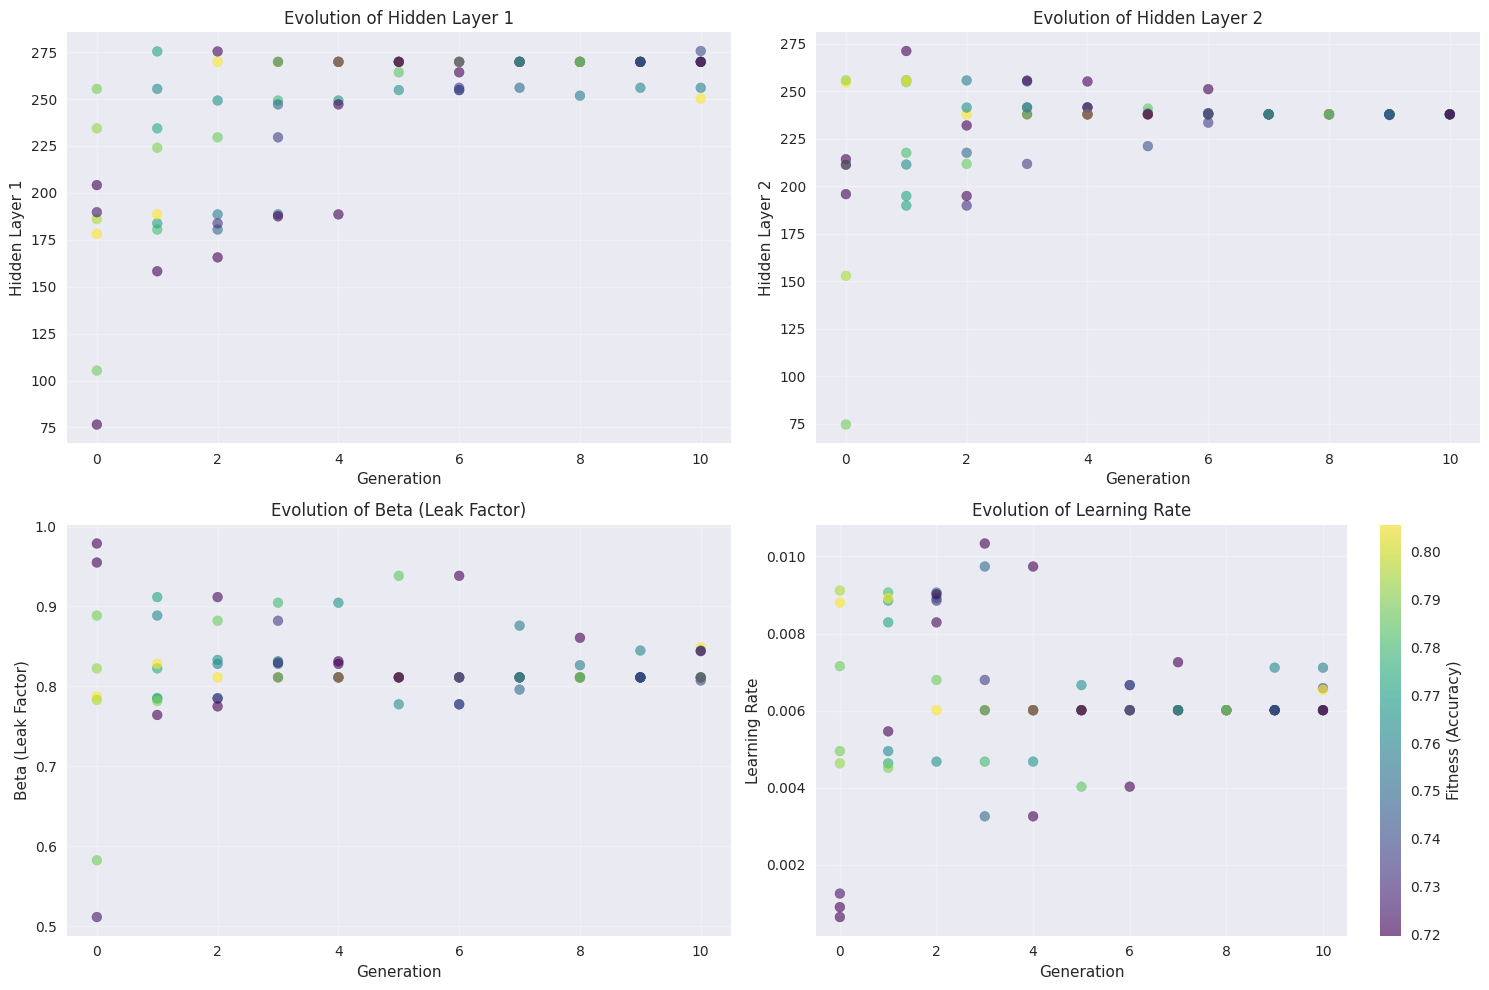


Best individual: [269.8223081818023, 237.8925408026081, 0.8113303188178032, 0.0060103535513523956]
Final accuracy: 0.8223
Architecture: 784 → 269 → 237 → 10
Beta: 0.811, Learning Rate: 0.006010


In [ ]:
def run_evolution():
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    
    populations_history = []

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields

    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    populations_history.append([ind[:] + [ind.fitness.values[0]] for ind in pop])
    hof.update(pop)
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(pop), **record)
    print(logbook.stream)
    
    for gen in range(1, 11):  
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5: 
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < 0.3: 
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        populations_history.append([ind[:] + [ind.fitness.values[0]] for ind in pop])
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)

    print("\nGenerating visualizations...")

    fig1 = plot_evolution_progress(logbook)
    plt.savefig('evolution_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    min_fitness = min(logbook.select('min'))
    max_fitness = max(logbook.select('max'))
    
    plt.figure(figsize=(18, 12))
    for i in range(min(12, len(populations_history))):
        plt.subplot(3, 4, i+1)
        pop_data = []
        for ind_data in populations_history[i]:
            ind = creator.Individual(ind_data[:4])
            ind.fitness.values = (ind_data[4],)
            pop_data.append(ind)

        fitness_vals = [ind.fitness.values[0] for ind in pop_data]
        hidden1_vals = [ind[0] for ind in pop_data]
        hidden2_vals = [ind[1] for ind in pop_data]
        
        scatter = plt.scatter(hidden1_vals, hidden2_vals, c=fitness_vals, 
                            cmap='viridis', s=60, alpha=0.7, vmin=min_fitness, vmax=max_fitness)
        plt.xlabel('Hidden1')
        plt.ylabel('Hidden2')
        plt.title(f'Gen {i}')
        plt.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=plt.gca())
    plt.tight_layout()
    plt.savefig('population_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig3 = plot_architecture_evolution(populations_history)
    plt.savefig('architecture_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nBest individual: {hof[0]}")
    print(f"Final accuracy: {hof[0].fitness.values[0]:.4f}")
    print(f"Architecture: 784 → {int(hof[0][0])} → {int(hof[0][1])} → 10")
    print(f"Beta: {hof[0][2]:.3f}, Learning Rate: {hof[0][3]:.6f}")

if __name__ == '__main__':
    run_evolution()